In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact
import time

In [13]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12,4)

# Efficient Vectorized Numerical Integration with SciPy 

In our research, we often have to repeatedly integrate a differential equation with different initial parameters, driving frequencies, driving forces, etc. 

In this notebook, I will explore how to implement these efficiently using SciPy. Specifically, I will look at the damped, driven Harmonic oscillator, and perhaps later, at the Duffing oscillator. 

For now, I will focus on trying to vectorize the solution of a large number of simultaneous problems, such as varying initial conditions. Later, I may look at speeding up the numerical integration itself using cython.

## The basics: the equation we will look at

We will consider the equation: 

$$
mx'' + cx' + kx = F_0 \cos(\omega t)
$$

This is a driven, damped harmonic oscillator.

## Simple implementation

A simple way to solve this equation is using the `solve_ivp()` routine of scipy: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

This is how it could look like:

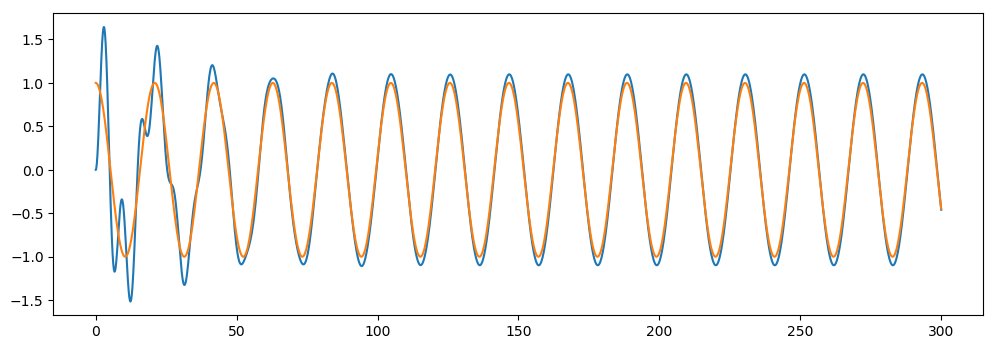

In [47]:
m = 1
c = 0.1
k = 1
F0 = 1
w = 0.3

def dydt(t,y):
    x = y[0]
    v = y[1]
    dxdt = v
    dvdt = (F0*np.cos(w*t) - c*v - k*x)/m
    return (dxdt, dvdt)

T = 300
ts = 0.1
N = int(T/ts)
t = np.linspace(0,T,N)

sol = solve_ivp(dydt, [0,T], [0,0], t_eval=t)
x = sol.y[0]

plt.plot(t,x)
plt.plot(t,F0*np.cos(w*t))

Also handy: it is easy to demodulate this to find the steady state amplitude and phase:

In [45]:
I = x*np.cos(w*t)
Q = x*np.sin(w*t)

# Assuming we've reached steady state by 50% of the time into the simulation
I = np.average(I[len(I)//2:])*2
Q = np.average(Q[len(Q)//2:])*2

print("I %.2f" % I)
print("Q %.2f" % Q)
print("Amp %.2f" % (np.sqrt(I**2+Q**2)))
print("Ph  %.2f" % (np.arctan2(Q,I)/np.pi*180))

I 1.03
Q 0.05
Amp 1.03
Ph  2.61


Fun: let's make an interactive widget out of it! It's pretty fast, so we can even just integrate on the fly.

In [75]:
def update(wd=1):
    global w 
    w = wd
    sol = solve_ivp(dydt, [0,T], [0,0], t_eval=t)
    x = sol.y[0]
    plt.plot(t,x)
    plt.plot(t,F0*np.cos(w*t))

interact(update,wd=(0.0,2,0.05))

interactive(children=(FloatSlider(value=1.0, description='wd', max=2.0, step=0.05), Output()), _dom_classes=('…

<function __main__.update(wd=1)>

## Next step: a frequency sweep

We will often be interested in calculating not just the response due to one frequency, but let's say the for a range of frequencies. 

Let's try this the simple way:

In [67]:
Nw = 500
wd = np.geomspace(0.1,2,Nw)

I = np.empty(Nw)
Q = np.empty(Nw)

t1 = time.time()

for i in range(Nw):
    global w
    w = wd[i]
    sol = solve_ivp(dydt, [0,T], [0,0], t_eval=t)
    x = sol.y[0]
    I[i] = np.average((x*np.cos(w*t))[N//2:])
    Q[i] = np.average((x*np.sin(w*t))[N//2:])
    
t2 = time.time()
print("Execution time: %.2f " % (t2-t1))

Execution time: 19.25 


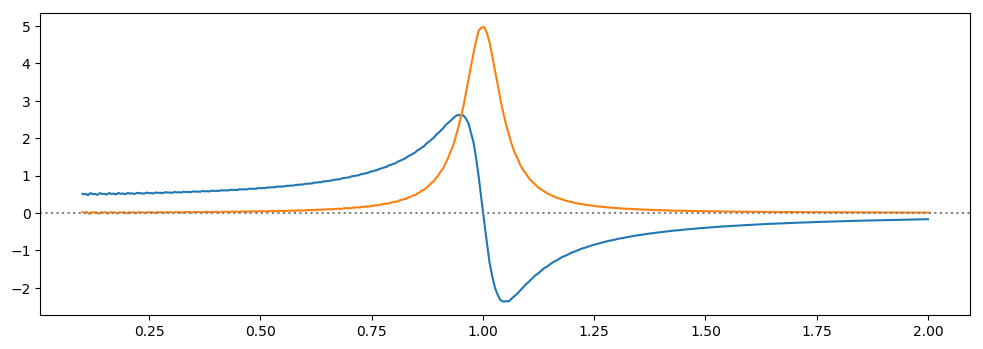

In [74]:
plt.plot(wd,I)
plt.plot(wd,Q)
plt.axhline(0,ls=':',c='grey')

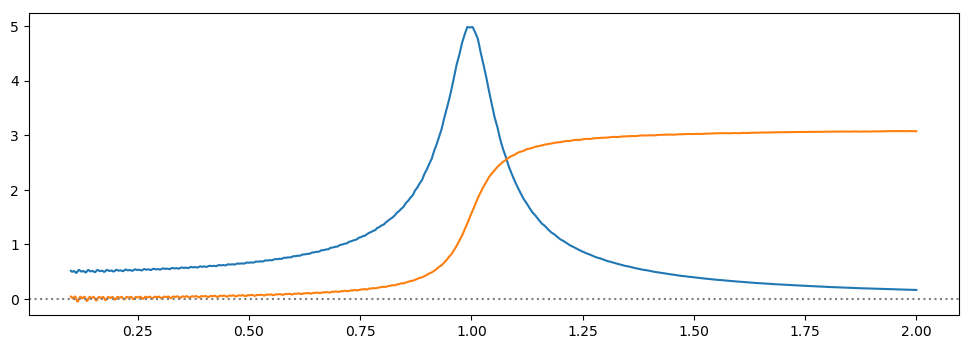

In [76]:
plt.plot(wd,np.abs(I+1j*Q))
plt.plot(wd,np.angle(I+1j*Q))
plt.axhline(0,ls=':',c='grey')

To make any decent kind of plot, we need 500 points, and this already takes quite some time (20 seconds!)

Can we do this faster in a smart way? I think we can if we have solve_ivp work with vector inputs instead of scalar ones. 

## Vector example with solve_ivp

Let's see if we can be clever somehow.


Let's say I define a vector `y` that is 500 copies of `x` and 500 copies of `v`:

```
y[0] = x_f0
y[1] = x_f1
...
y[499] = x_f499
y[500] = v_f0
y[501] = v_f1
...
y[999] = v_f499
```

This should then work: 

```
x = y[:500]
v = y[500:]
```


Computation time: 0.14


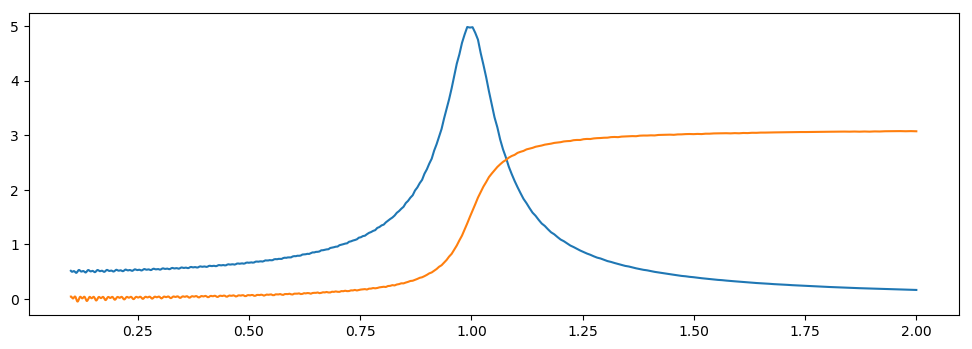

In [116]:
m = 1
c = 0.1
k = 1
F0 = 1

Nw = 500
w = np.geomspace(0.1,2,Nw)

# The trick is: we need 
def dydt_vector(t,y):
    x = y[:len(y)//2]
    v = y[len(y)//2:]
    dxdt = v
    dvdt = (F0*np.cos(w*t) - c*v - k*x)/m
    return np.concatenate([dxdt,dvdt],axis=None)

T = 300
ts = 0.1
Nt = int(T/ts)
t = np.linspace(0,T,Nt)

# Somehow I need to figure out 
x0 = np.zeros(Nw)
v0 = np.zeros(Nw)
y0 = np.concatenate([x0,v0],axis=None)

# Maybe this will just work? 
t1 = time.time()
sol = solve_ivp(dydt_vector, [0,T], y0, t_eval=t)
t2 = time.time()
print("Computation time: %.2f" %(t2-t1))

# It seems to!
x = sol.y[0:Nw,:]

# Cool use ouf outer product (!), took me a while to think about it
I_ref = np.cos(np.outer(w,t))
Q_ref = np.sin(np.outer(w,t))

# and some more indexing and averaging magic :)
I = np.average((x*I_ref)[:,Nt//2:], axis=1)
Q = np.average((x*Q_ref)[:,Nt//2:], axis=1)

# And plot
plt.plot(w,np.abs(I+1j*Q))
plt.plot(w,np.angle(I+1j*Q))


Pretty awesome! We've reduced the computation time by a factor of more than 100!

## Varying initial conditions 

Let's try the same thing but now for the Duffing oscillator. 

We'll take the parameters from my CS assignment:

```
m = 1
k = 1
c = 0.2
F0 = 2.5
w = 1.6
alpha = 0.05
```

We want x0 to range from -20 to 20 and v0 to range from -60 to 60 in say 100x100 points. Our time integration should run for 100 seconds. We will start with 100 points, but then expand that.

In [183]:
m = 1
k = 1
c = 0.2
F0 = 2.5
w = 1.6
alpha = 0.05

Ni = 100
xr = 20
vr = 60
x0 = np.linspace(-xr,xr,Ni)
v0 = np.linspace(-vr,vr,Ni)

# This takes some thinking, see debugging below!
# x will come first in the linear array, then corresponding v 
# elements
y0 = np.array(np.meshgrid(x0,v0)).flatten()

def dydt_vDuff(t,y):
    x = y[:len(y)//2]
    v = y[len(y)//2:]
    dxdt = v
    dvdt = (F0*np.cos(w*t) - c*v - k*x - alpha*x**3)/m
    return np.concatenate([dxdt,dvdt],axis=None)

# Let's try it!
t1 = time.time()
sol = solve_ivp(dydt_vDuff, [0,T], y0, t_eval=t)
t2 = time.time()
print("Computation time: %.2f" %(t2-t1))

Computation time: 2.67


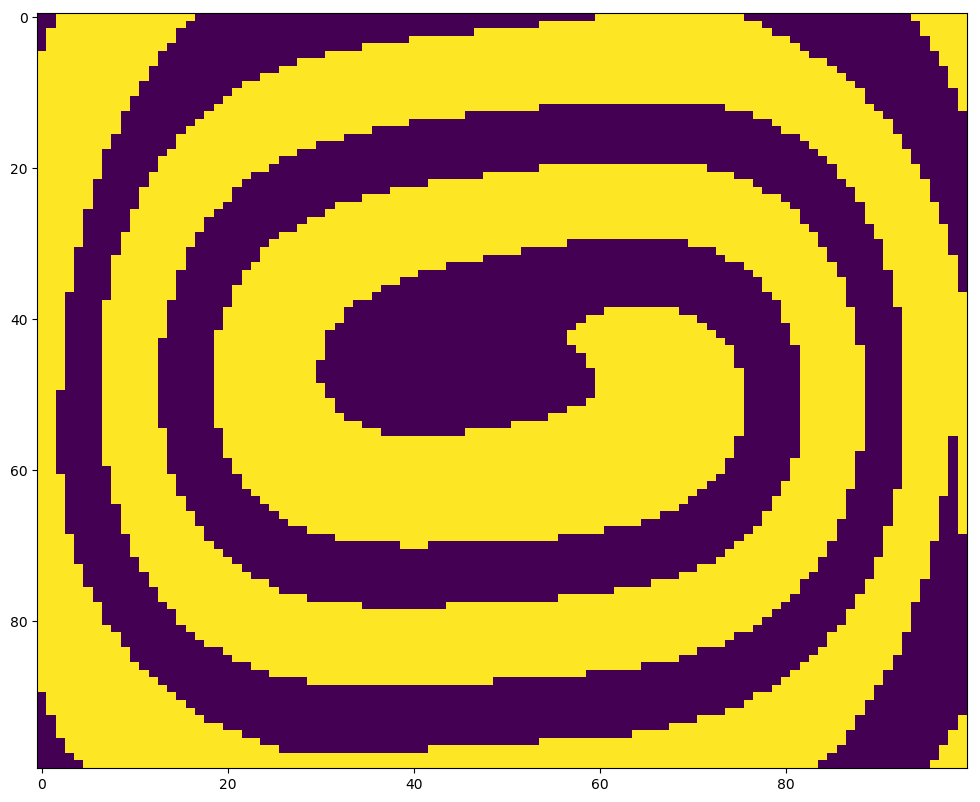

In [184]:
# Let's do a simple max to find steady state amp
x = sol.y[0:len(y0)//2,Nt//2:]
xmax = np.reshape(np.max(x,axis=1),[Ni,Ni])
plt.figure(figsize=(12,10))
plt.imshow(xmax, aspect='auto')

Amazing! Using a hand coded for loop, this was taking 5 minutes for a 100x100 array of initial conditions. Now it's taking 2.6 seconds!

## Meshgrid debugging



In [139]:
def print_array(A):
    print(np.around(A,decimals=2))

In [140]:
foo = np.array(np.meshgrid(x0,v0))
print(foo.shape)
print_array(foo)

(2, 10, 10)
[[[-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]]

 [[-60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.  ]
  [-46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67]
  [-33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33]
  [-20.   -20.   -20.   

In [141]:
flatfoo = foo.flatten()
print_array(flatfoo)

[-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.
 -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.
 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67
 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33
 -20.   -20.   -20.   -20.   -20.   -20.   -20.   -20.   -20.   -20.
  -6.67  -6.67  -6.67  -6.67  

In [143]:
unflat_foo = np.reshape(flatfoo, [2,10,10])
print_array(unflat_foo)

[[[-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]
  [-20.   -15.56 -11.11  -6.67  -2.22   2.22   6.67  11.11  15.56  20.  ]]

 [[-60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.   -60.  ]
  [-46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67 -46.67]
  [-33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33 -33.33]
  [-20.   -20.   -20.   -20.   -20. 